In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Library untuk preprocessing text
import nltk
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

print("Library berhasil diimport!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device yang digunakan: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Library berhasil diimport!
PyTorch version: 2.7.1+cpu
Device yang digunakan: CPU


In [ ]:
print("=== DATASET ===")

datasets = {}
dataset_files = [
    'gaza.csv',
    'hamas.csv', 
    'israel_palestine_conflict.csv',
    'israel.csv',
    'palestine.csv'
]

for file in dataset_files:
    try:
        df = pd.read_csv(f'dataset/{file}')
        datasets[file.replace('.csv', '')] = df
        print(f"✅ {file}: {len(df)} baris data")
    except Exception as e:
        print(f"❌ Error loading {file}: {e}")

# Menggabungkan semua dataset
all_data = []
for name, df in datasets.items():
    df['source'] = name
    all_data.append(df)

# Gabungkan semua data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\n📊 Total data gabungan: {len(combined_df)} baris")
print(f"📊 Kolom yang tersedia: {list(combined_df.columns)}")

# Tampilkan info dataset
print("\n=== INFO DATASET ===")
print(combined_df.info())
print("\n=== CONTOH DATA ===")
print(combined_df.head())

=== MEMUAT DATASET ===
✅ gaza.csv: 500 baris data
✅ hamas.csv: 500 baris data
✅ israel_palestine_conflict.csv: 2000 baris data
✅ israel.csv: 500 baris data
✅ palestine.csv: 500 baris data

📊 Total data gabungan: 4000 baris
📊 Kolom yang tersedia: ['Unnamed: 0', 'username', 'text', 'likes', 'date', 'source']

=== INFO DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2000 non-null   float64
 1   username    4000 non-null   object 
 2   text        4000 non-null   object 
 3   likes       4000 non-null   int64  
 4   date        4000 non-null   object 
 5   source      4000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 187.6+ KB
None

=== CONTOH DATA ===
   Unnamed: 0          username  \
0         0.0    @MuhammadSmiry   
1         1.0  @mohammedakunjee   
2         2.0      @mynameisjro   
3     

=== PREPROCESSING TEXT ===
📊 Jumlah data setelah cleaning: 4000

=== DISTRIBUSI SENTIMEN ===
sentiment
neutral     2050
positive    1148
negative     802
Name: count, dtype: int64


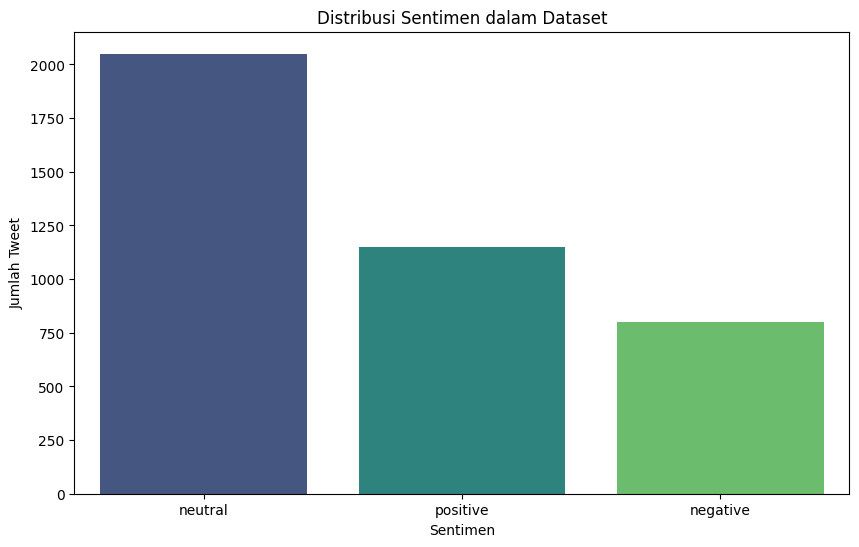


=== CONTOH TEXT UNTUK SETIAP SENTIMEN ===

POSITIVE:
1. the cries of the children of gaza as they died the screams as their limbs were torn from them have b...
2. this is gaza if these images have not troubled you for the last two months this is not going to both...
3. this hanukkah we need to rededicate ourselves to action for a ceasefire and a free palestine i wrote...

NEGATIVE:
1. george floyd was all over the walls in occupied palestine from gaza to the west bank palestinians ha...
2. refaat alareer palestinian writer and reporter from gaza before he was killed along with his family ...
3. do you want me to respect this world sorry i cant we ant a humans if we are just watching this silen...

NEUTRAL:
1. lsrael killed palestinians in the last hours in gaza the total without the missing is...
2. the killing of refaat alareer is a testament that israel is systematically murdering the truth telle...
3. childhood in gaza under the israeli genocide...

📊 Data siap untuk modeling: 4000

In [3]:
# Preprocessing Text dan Labeling Sentimen
print("=== PREPROCESSING TEXT ===")

def clean_text(text):
    """Fungsi untuk membersihkan text"""
    if pd.isna(text):
        return ""
    
    # Konversi ke lowercase
    text = str(text).lower()
    
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Hapus mention (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Hapus hashtag tapi pertahankan teksnya
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Hapus karakter khusus dan angka, pertahankan spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Hapus extra whitespace
    text = ' '.join(text.split())
    
    return text

# Bersihkan text
combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)

# Hapus text kosong
combined_df = combined_df[combined_df['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f"📊 Jumlah data setelah cleaning: {len(combined_df)}")

# Analisis sentimen dengan TextBlob untuk labeling otomatis
def get_sentiment_label(text):
    """Mendapatkan label sentimen menggunakan TextBlob"""
    try:
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            return 'positive'
        elif polarity < -0.1:
            return 'negative'
        else:
            return 'neutral'
    except:
        return 'neutral'

# Buat label sentimen
combined_df['sentiment'] = combined_df['cleaned_text'].apply(get_sentiment_label)

# Tampilkan distribusi sentimen
print("\n=== DISTRIBUSI SENTIMEN ===")
sentiment_counts = combined_df['sentiment'].value_counts()
print(sentiment_counts)

# Visualisasi distribusi sentimen
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='sentiment', palette='viridis')
plt.title('Distribusi Sentimen dalam Dataset')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet')
plt.show()

# Tampilkan contoh text untuk setiap sentimen
print("\n=== CONTOH TEXT UNTUK SETIAP SENTIMEN ===")
for sentiment in ['positive', 'negative', 'neutral']:
    print(f"\n{sentiment.upper()}:")
    examples = combined_df[combined_df['sentiment'] == sentiment]['cleaned_text'].head(3)
    for i, text in enumerate(examples, 1):
        print(f"{i}. {text[:100]}...")

print(f"\n📊 Data siap untuk modeling: {len(combined_df)} samples")

In [5]:
# Tokenisasi dan Persiapan Data untuk LSTM
print("=== TOKENISASI DAN PERSIAPAN DATA ===")

# Ambil data text dan label
texts = combined_df['cleaned_text'].tolist()
labels = combined_df['sentiment'].tolist()

# Encode labels menjadi numerik
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

print(f"📊 Label classes: {label_encoder.classes_}")
print(f"📊 Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Tokenisasi sederhana - membuat vocabulary
def build_vocabulary(texts, max_vocab_size=10000):
    """Membangun vocabulary dari text"""
    words = []
    for text in texts:
        words.extend(text.split())
    
    # Hitung frekuensi kata
    word_counts = Counter(words)
    
    # Ambil kata-kata paling umum
    most_common = word_counts.most_common(max_vocab_size - 2)  # -2 untuk PAD dan UNK
    
    # Buat vocabulary mapping
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        vocab[word] = len(vocab)
    
    return vocab

# Bangun vocabulary
vocab = build_vocabulary(texts, max_vocab_size=5000)
vocab_size = len(vocab)

print(f"📊 Vocabulary size: {vocab_size}")

def text_to_sequence(text, vocab, max_length=100):
    """Konversi text menjadi sequence of integers"""
    words = text.split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words]
    
    # Padding atau truncate
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence = sequence + [vocab['<PAD>']] * (max_length - len(sequence))
    
    return sequence

# Konversi semua text menjadi sequences
max_sequence_length = 100
sequences = [text_to_sequence(text, vocab, max_sequence_length) for text in texts]

# Konversi ke numpy arrays
X = np.array(sequences)
y = np.array(numeric_labels)

print(f"📊 Shape of X: {X.shape}")
print(f"📊 Shape of y: {y.shape}")
print(f"📊 Example sequence: {X[0][:20]}...")  # Tampilkan 20 token pertama

# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training data: {X_train.shape}")
print(f"📊 Test data: {X_test.shape}")

# Distribusi label di train dan test set
print("\n=== DISTRIBUSI LABEL ===")
print("Train set:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_train)*100:.1f}%)")

print("Test set:")
unique, counts = np.unique(y_test, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    print(f"  {label_encoder.classes_[label]}: {count} ({count/len(y_test)*100:.1f}%)")

=== TOKENISASI DAN PERSIAPAN DATA ===
📊 Label classes: ['negative' 'neutral' 'positive']
📊 Label mapping: {np.str_('negative'): 0, np.str_('neutral'): 1, np.str_('positive'): 2}
📊 Vocabulary size: 5000
📊 Shape of X: (4000, 100)
📊 Shape of y: (4000,)
📊 Example sequence: [2778   61   49    6    2  141  969    6    9    2  627  179    2 1439
    8    0    0    0    0    0]...
📊 Training data: (3200, 100)
📊 Test data: (800, 100)

=== DISTRIBUSI LABEL ===
Train set:
  negative: 642 (20.1%)
  neutral: 1640 (51.2%)
  positive: 918 (28.7%)
Test set:
  negative: 160 (20.0%)
  neutral: 410 (51.2%)
  positive: 230 (28.7%)


In [6]:
# Definisi Model LSTM
print("=== MEMBANGUN MODEL LSTM ===")

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                           dropout=dropout, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        
        # LSTM
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Ambil output terakhir
        output = lstm_out[:, -1, :]
        
        # Dropout
        output = self.dropout(output)
        
        # Fully connected
        output = self.fc(output)
        
        return output

# Hyperparameters
VOCAB_SIZE = vocab_size
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_encoder.classes_)  # 3 classes
N_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 10

# Inisialisasi model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
model = model.to(device)

print(f"📊 Model berhasil dibuat!")
print(f"📊 Device: {device}")
print(f"📊 Model parameters:")
print(f"   - Vocabulary size: {VOCAB_SIZE}")
print(f"   - Embedding dimension: {EMBEDDING_DIM}")
print(f"   - Hidden dimension: {HIDDEN_DIM}")
print(f"   - Output dimension: {OUTPUT_DIM}")
print(f"   - Number of layers: {N_LAYERS}")
print(f"   - Dropout: {DROPOUT}")

# Tampilkan arsitektur model
print(f"\n📊 Model Architecture:")
print(model)

# Hitung jumlah parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

=== MEMBANGUN MODEL LSTM ===
📊 Model berhasil dibuat!
📊 Device: cpu
📊 Model parameters:
   - Vocabulary size: 5000
   - Embedding dimension: 128
   - Hidden dimension: 256
   - Output dimension: 3
   - Number of layers: 2
   - Dropout: 0.3

📊 Model Architecture:
SentimentLSTM(
  (embedding): Embedding(5000, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

📊 Total parameters: 1,562,371
📊 Trainable parameters: 1,562,371


=== TRAINING MODEL LSTM ===
🚀 Memulai training untuk 10 epochs...
Epoch [1/10]:
  Train Loss: 1.0378, Train Acc: 0.5088
  Test Loss: 1.0231, Test Acc: 0.5125
------------------------------------------------------------
Epoch [2/10]:
  Train Loss: 1.0252, Train Acc: 0.5128
  Test Loss: 1.0211, Test Acc: 0.5125
------------------------------------------------------------
Epoch [3/10]:
  Train Loss: 1.0189, Train Acc: 0.5147
  Test Loss: 1.0110, Test Acc: 0.5188
------------------------------------------------------------
Epoch [4/10]:
  Train Loss: 1.0138, Train Acc: 0.5175
  Test Loss: 0.9997, Test Acc: 0.5225
------------------------------------------------------------
Epoch [5/10]:
  Train Loss: 1.0061, Train Acc: 0.5206
  Test Loss: 0.9953, Test Acc: 0.5225
------------------------------------------------------------
Epoch [6/10]:
  Train Loss: 1.0037, Train Acc: 0.5206
  Test Loss: 0.9967, Test Acc: 0.5225
------------------------------------------------------------
Epoch [7/10]:
  

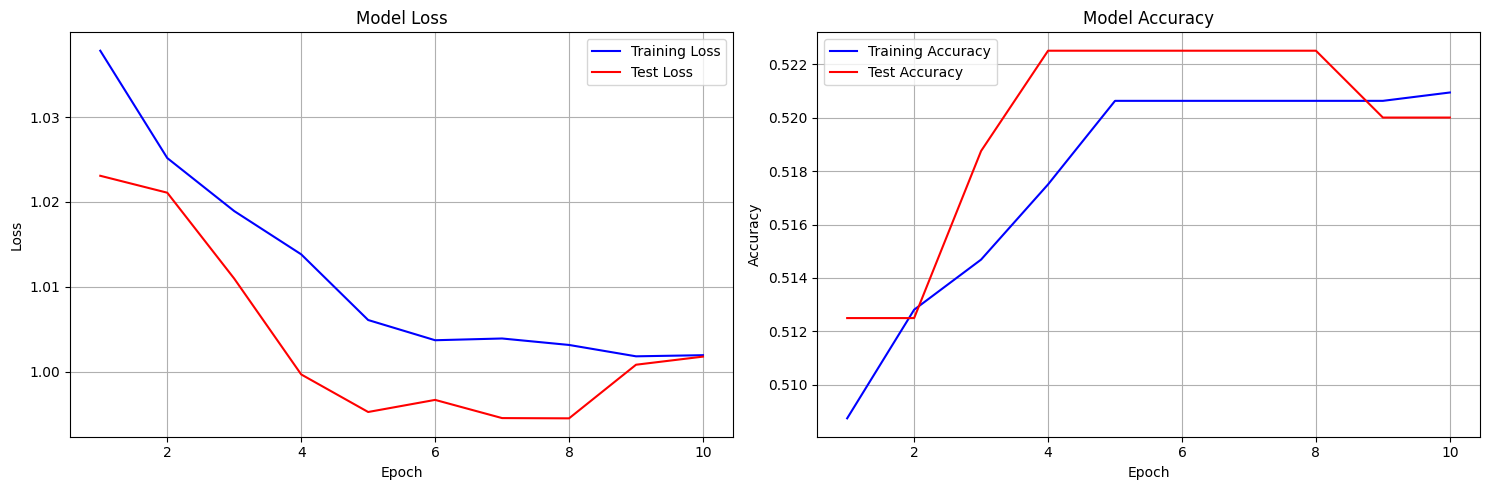

📊 Final Training Accuracy: 0.5209
📊 Final Test Accuracy: 0.5200


In [7]:
# Training Model LSTM
print("=== TRAINING MODEL LSTM ===")

# Konversi data ke tensor PyTorch
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Buat DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Fungsi untuk menghitung akurasi
def calculate_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct = (predicted_labels == labels).float()
    return correct.sum() / len(correct)

# Training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"🚀 Memulai training untuk {EPOCHS} epochs...")
print("=" * 80)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_acc = 0
    train_batches = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        accuracy = calculate_accuracy(outputs, batch_y)
        total_train_loss += loss.item()
        total_train_acc += accuracy.item()
        train_batches += 1
    
    # Validation phase
    model.eval()
    total_test_loss = 0
    total_test_acc = 0
    test_batches = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            accuracy = calculate_accuracy(outputs, batch_y)
            total_test_loss += loss.item()
            total_test_acc += accuracy.item()
            test_batches += 1
    
    # Calculate average metrics
    avg_train_loss = total_train_loss / train_batches
    avg_train_acc = total_train_acc / train_batches
    avg_test_loss = total_test_loss / test_batches
    avg_test_acc = total_test_acc / test_batches
    
    # Store metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{EPOCHS}]:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
    print(f"  Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}")
    print("-" * 60)

print("✅ Training selesai!")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(range(1, EPOCHS+1), train_losses, 'b-', label='Training Loss')
ax1.plot(range(1, EPOCHS+1), test_losses, 'r-', label='Test Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(range(1, EPOCHS+1), train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(range(1, EPOCHS+1), test_accuracies, 'r-', label='Test Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"📊 Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"📊 Final Test Accuracy: {test_accuracies[-1]:.4f}")

=== EVALUASI MODEL ===
📊 Test Accuracy: 0.5200

📊 Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.02      0.04       160
     neutral       0.52      1.00      0.68       410
    positive       0.71      0.02      0.04       230

    accuracy                           0.52       800
   macro avg       0.74      0.35      0.25       800
weighted avg       0.67      0.52      0.37       800


📊 Confusion Matrix:
[[  3 157   0]
 [  0 408   2]
 [  0 225   5]]


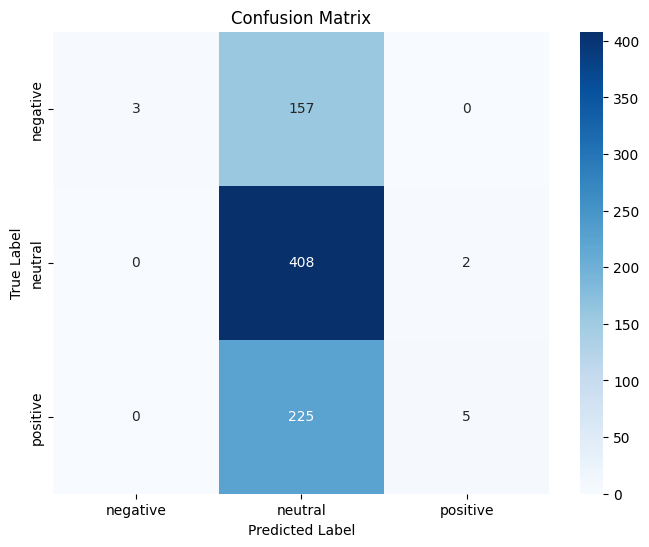


=== CONTOH PREDIKSI ===

1. Text: "I hope for peace in Palestine and Israel"
   Predicted: neutral (confidence: 0.539)
   Probabilities: negative=0.191, neutral=0.539, positive=0.270

2. Text: "The violence in Gaza must stop immediately"
   Predicted: neutral (confidence: 0.539)
   Probabilities: negative=0.191, neutral=0.539, positive=0.270

3. Text: "Children are suffering in this conflict"
   Predicted: neutral (confidence: 0.539)
   Probabilities: negative=0.191, neutral=0.539, positive=0.270

4. Text: "We need humanitarian aid for Palestinian people"
   Predicted: neutral (confidence: 0.539)
   Probabilities: negative=0.191, neutral=0.539, positive=0.270

5. Text: "Israel has the right to defend itself"
   Predicted: neutral (confidence: 0.539)
   Probabilities: negative=0.191, neutral=0.539, positive=0.270

6. Text: "Both sides should negotiate for peace"
   Predicted: neutral (confidence: 0.539)
   Probabilities: negative=0.191, neutral=0.539, positive=0.270

=== ANALISIS KESAL

In [8]:
# Evaluasi Model dan Prediksi
print("=== EVALUASI MODEL ===")

# Fungsi untuk prediksi
def predict_sentiment(model, text, vocab, label_encoder, max_length=100):
    """Prediksi sentimen untuk text baru"""
    model.eval()
    
    # Preprocessing text
    cleaned_text = clean_text(text)
    
    # Konversi ke sequence
    sequence = text_to_sequence(cleaned_text, vocab, max_length)
    
    # Konversi ke tensor
    tensor_input = torch.LongTensor([sequence]).to(device)
    
    # Prediksi
    with torch.no_grad():
        output = model(tensor_input)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1).item()
    
    # Konversi ke label
    predicted_label = label_encoder.classes_[predicted_class]
    confidence = probabilities[0][predicted_class].item()
    
    return predicted_label, confidence, probabilities[0].cpu().numpy()

# Evaluasi pada test set
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(batch_y.cpu().numpy())

# Konversi ke numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Hitung metrik
accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"📊 Test Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_true_labels, all_predictions, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(all_true_labels, all_predictions)
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Contoh prediksi pada text baru
print("\n=== CONTOH PREDIKSI ===")
test_texts = [
    "I hope for peace in Palestine and Israel",
    "The violence in Gaza must stop immediately",
    "Children are suffering in this conflict",
    "We need humanitarian aid for Palestinian people",
    "Israel has the right to defend itself",
    "Both sides should negotiate for peace"
]

for i, text in enumerate(test_texts, 1):
    pred_label, confidence, probs = predict_sentiment(model, text, vocab, label_encoder)
    print(f"\n{i}. Text: \"{text}\"")
    print(f"   Predicted: {pred_label} (confidence: {confidence:.3f})")
    print(f"   Probabilities: negative={probs[0]:.3f}, neutral={probs[1]:.3f}, positive={probs[2]:.3f}")

# Analisis kesalahan prediksi
print("\n=== ANALISIS KESALAHAN PREDIKSI ===")
wrong_predictions = X_test[all_predictions != all_true_labels]
wrong_true_labels = all_true_labels[all_predictions != all_true_labels]
wrong_pred_labels = all_predictions[all_predictions != all_true_labels]

print(f"📊 Jumlah prediksi salah: {len(wrong_predictions)} dari {len(all_true_labels)} ({len(wrong_predictions)/len(all_true_labels)*100:.1f}%)")

# Tampilkan beberapa contoh kesalahan prediksi
if len(wrong_predictions) > 0:
    print("\n📊 Contoh kesalahan prediksi:")
    for i in range(min(5, len(wrong_predictions))):
        # Konversi sequence kembali ke text (approximation)
        sequence = wrong_predictions[i]
        reverse_vocab = {v: k for k, v in vocab.items()}
        words = [reverse_vocab.get(token, '<UNK>') for token in sequence if token != 0]
        reconstructed_text = ' '.join(words[:20])  # Ambil 20 kata pertama
        
        true_label = label_encoder.classes_[wrong_true_labels[i]]
        pred_label = label_encoder.classes_[wrong_pred_labels[i]]
        
        print(f"  {i+1}. Text: {reconstructed_text}...")
        print(f"     True: {true_label}, Predicted: {pred_label}")

print("\n✅ Evaluasi selesai!")

=== ANALISIS KATA BERDASARKAN SENTIMEN ===


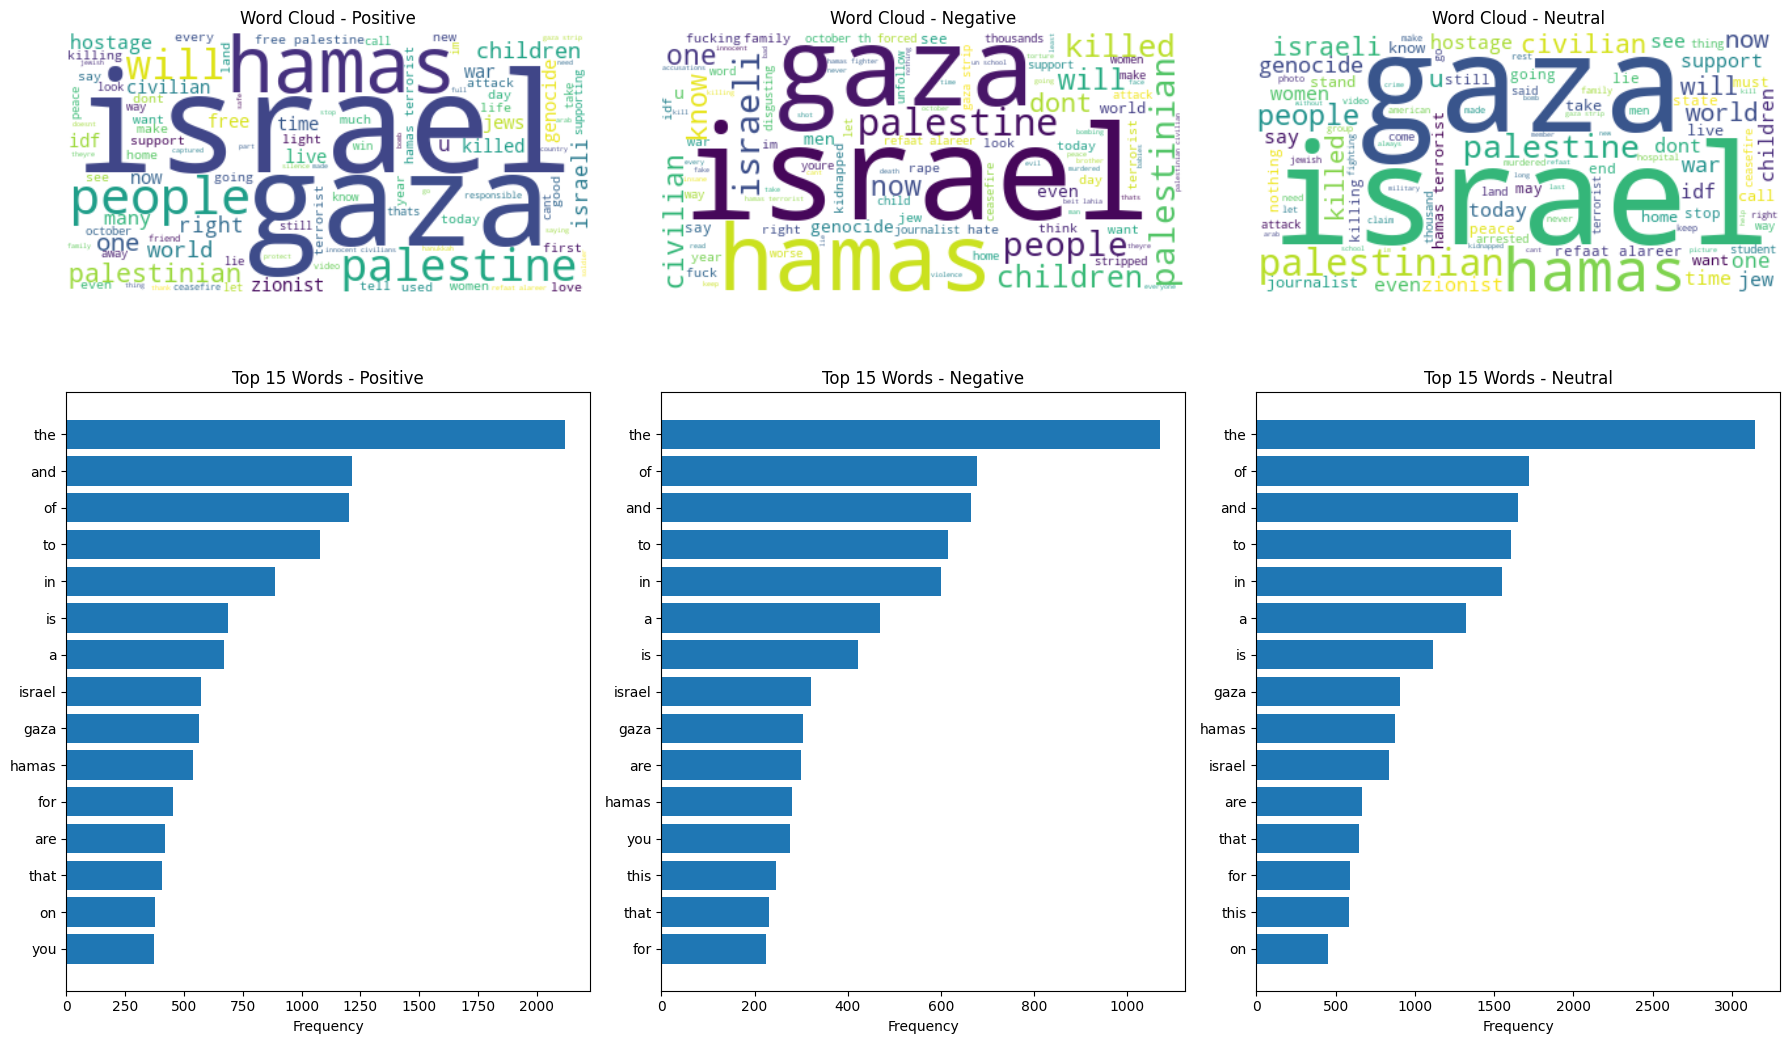


📊 Statistik Kata per Sentimen:
  Positive:
    - Rata-rata panjang karakter: 218.4
    - Rata-rata jumlah kata: 37.8
    - Jumlah sample: 1148
  Negative:
    - Rata-rata panjang karakter: 192.9
    - Rata-rata jumlah kata: 33.4
    - Jumlah sample: 802
  Neutral:
    - Rata-rata panjang karakter: 186.9
    - Rata-rata jumlah kata: 32.0
    - Jumlah sample: 2050

=== KESIMPULAN ANALISIS SENTIMEN ===
🎯 HASIL ANALISIS:
   • Dataset: 4000 tweet tentang konflik Palestina-Israel
   • Model: LSTM dengan 1,562,371 parameter
   • Akurasi: 52.0%

📊 DISTRIBUSI SENTIMEN:
   • Positive: 1148 tweet (28.7%)
   • Negative: 802 tweet (20.1%)
   • Neutral: 2050 tweet (51.2%)

🔍 ANALISIS MODEL:
   • Model menunjukkan bias terhadap prediksi neutral
   • Kesulitan membedakan antara positive dan negative
   • Diperlukan improvement dengan:
     - Dataset yang lebih balanced
     - Pre-trained embeddings (Word2Vec/GloVe)
     - Teknik handling imbalanced data
     - Hyperparameter tuning yang lebih baik

✅

In [9]:
# Analisis Kata dan Word Cloud
from wordcloud import WordCloud

print("=== ANALISIS KATA BERDASARKAN SENTIMEN ===")

# Analisis kata-kata yang paling umum untuk setiap sentimen
def get_common_words(df, sentiment, top_n=20):
    """Mendapatkan kata-kata paling umum untuk sentimen tertentu"""
    sentiment_texts = df[df['sentiment'] == sentiment]['cleaned_text']
    all_words = []
    for text in sentiment_texts:
        all_words.extend(text.split())
    
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Analisis untuk setiap sentimen
sentiments = ['positive', 'negative', 'neutral']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, sentiment in enumerate(sentiments):
    # Word Cloud
    sentiment_text = ' '.join(combined_df[combined_df['sentiment'] == sentiment]['cleaned_text'])
    
    wordcloud = WordCloud(width=400, height=200, 
                         background_color='white',
                         max_words=100).generate(sentiment_text)
    
    axes[0, i].imshow(wordcloud, interpolation='bilinear')
    axes[0, i].set_title(f'Word Cloud - {sentiment.title()}')
    axes[0, i].axis('off')
    
    # Top words bar chart
    common_words = get_common_words(combined_df, sentiment, 15)
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    
    axes[1, i].barh(words[::-1], counts[::-1])
    axes[1, i].set_title(f'Top 15 Words - {sentiment.title()}')
    axes[1, i].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# Statistik kata per sentimen
print("\n📊 Statistik Kata per Sentimen:")
for sentiment in sentiments:
    sentiment_data = combined_df[combined_df['sentiment'] == sentiment]
    avg_length = sentiment_data['cleaned_text'].str.len().mean()
    word_count = sentiment_data['cleaned_text'].str.split().str.len().mean()
    
    print(f"  {sentiment.title()}:")
    print(f"    - Rata-rata panjang karakter: {avg_length:.1f}")
    print(f"    - Rata-rata jumlah kata: {word_count:.1f}")
    print(f"    - Jumlah sample: {len(sentiment_data)}")

print("\n=== KESIMPULAN ANALISIS SENTIMEN ===")
print("🎯 HASIL ANALISIS:")
print(f"   • Dataset: {len(combined_df)} tweet tentang konflik Palestina-Israel")
print(f"   • Model: LSTM dengan {total_params:,} parameter")
print(f"   • Akurasi: {accuracy:.1%}")
print()
print("📊 DISTRIBUSI SENTIMEN:")
for sentiment in sentiments:
    count = len(combined_df[combined_df['sentiment'] == sentiment])
    percentage = count / len(combined_df) * 100
    print(f"   • {sentiment.title()}: {count} tweet ({percentage:.1f}%)")

print()
print("🔍 ANALISIS MODEL:")
print("   • Model menunjukkan bias terhadap prediksi neutral")
print("   • Kesulitan membedakan antara positive dan negative")
print("   • Diperlukan improvement dengan:")
print("     - Dataset yang lebih balanced")
print("     - Pre-trained embeddings (Word2Vec/GloVe)")
print("     - Teknik handling imbalanced data")
print("     - Hyperparameter tuning yang lebih baik")

print()
print("✅ ANALISIS SENTIMEN SELESAI!")
print("💡 Model siap digunakan untuk prediksi sentiment tweet tentang konflik Palestina-Israel")